# YOLO検討ノート

In [1]:
from __future__ import unicode_literals
from __future__ import print_function
import sys
import os
import math
import random
import numpy as np
import scipy.io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import json

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import Variable, Function, Link, optimizers
from chainer import cuda
from chainer import serializers

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (9, 6) # グラフの表示サイズを変更

In [2]:
sys.version

'2.7.13 |Anaconda 4.3.0 (x86_64)| (default, Dec 20 2016, 23:05:08) \n[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'

In [3]:
cv2.__version__

'3.1.0'

In [4]:
chainer.__version__

'1.22.0'

## ネットワーク構成

In [5]:
xp = np

N_BOXES = 1
N_CLASSES = 26  # 0..25
                # F.softmax_cross_entropy()で扱うラベルが
                # 0始まりの必要があるため、便宜的に0を追加
N_GRID = 7
INPUT_SIZE = 448
N_CNN_LAYER = 7

In [6]:
(N_GRID**2) * ((N_BOXES * 5) + N_CLASSES)

1519

In [7]:
class YoloTinyCNN(chainer.Chain):
    def __init__(self):
        super(YoloTinyCNN, self).__init__(
            conv1  = L.Convolution2D(3,      16, ksize=3, stride=1, pad=1),
            conv2  = L.Convolution2D(None,   32, ksize=3, stride=1, pad=1),
            conv3  = L.Convolution2D(None,   64, ksize=3, stride=1, pad=1),
            conv4  = L.Convolution2D(None,  128, ksize=3, stride=1, pad=1),
            conv5  = L.Convolution2D(None,  256, ksize=3, stride=1, pad=1),
            conv6  = L.Convolution2D(None,  512, ksize=3, stride=1, pad=1),
            conv7  = L.Convolution2D(None, 1024, ksize=3, stride=1, pad=1),
            # addditonal layers for pretraining
            conv8  = L.Convolution2D(None, N_CLASSES, ksize=1, stride=1, pad=0),
        )
        self.train = True

    def forward(self, x):
        batch_size = x.data.shape[0]
        h = F.leaky_relu(self.conv1(x), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 224x224
        h = F.leaky_relu(self.conv2(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 112x112
        h = F.leaky_relu(self.conv3(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 56x56
        h = F.leaky_relu(self.conv4(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 28x28
        h = F.leaky_relu(self.conv5(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 14x14
        h = F.leaky_relu(self.conv6(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 7x7
        h = F.leaky_relu(self.conv7(h), slope=0.1)
        # additional layers for pretraining
        h = self.conv8(h)
        h = F.average_pooling_2d(h, h.data.shape[-1], stride=1, pad=0)
        # reshape result tensor
        h = F.reshape(h, (batch_size, -1))
        return h

    def __call__(self, x, t):
        h = self.forward(x)
        self.loss = F.softmax_cross_entropy(h, t)
        self.accuracy = F.accuracy(h, t)
        if self.train:
            return self.loss
        else:
            return F.softmax(h)

In [8]:
class YoloTiny(chainer.Chain):
    def __init__(self, gpu=-1):
        super(YoloTiny, self).__init__(
            conv1  = L.Convolution2D(3,      16, ksize=3, stride=1, pad=1),
            conv2  = L.Convolution2D(None,   32, ksize=3, stride=1, pad=1),
            conv3  = L.Convolution2D(None,   64, ksize=3, stride=1, pad=1),
            conv4  = L.Convolution2D(None,  128, ksize=3, stride=1, pad=1),
            conv5  = L.Convolution2D(None,  256, ksize=3, stride=1, pad=1),
            conv6 = L.Convolution2D(None,  512, ksize=3, stride=1, pad=1),
            conv7 = L.Convolution2D(None, 1024, ksize=3, stride=1, pad=1),
            conv8 = L.Convolution2D(None, 1024, ksize=3, stride=1, pad=1),
            conv9 = L.Convolution2D(None, 1024, ksize=3, stride=1, pad=1),
            fc1 = L.Linear(50176, 256), # (1024,7,7)=50176
            fc2 = L.Linear(None, 4096),
            fc3 = L.Linear(None, ((N_BOXES*5)+N_CLASSES) * (N_GRID**2))
        )
        self.train = False
        self.gpu = gpu
        if self.gpu >= 0: self.to_gpu()

    def forward(self, x):
        batch_size = x.data.shape[0]
        h = F.leaky_relu(self.conv1(x), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 224x224
        h = F.leaky_relu(self.conv2(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 112x112
        h = F.leaky_relu(self.conv3(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 56x56
        h = F.leaky_relu(self.conv4(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 28x28
        h = F.leaky_relu(self.conv5(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 14x14
        h = F.leaky_relu(self.conv6(h), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0) # 7x7
        h = F.leaky_relu(self.conv7(h), slope=0.1)
        h = F.leaky_relu(self.conv8(h), slope=0.1)
        h = F.leaky_relu(self.conv9(h), slope=0.1)
        h = F.leaky_relu(self.fc1(h), slope=0.1)
        h = F.dropout(h, train=self.train, ratio=0.5)
        h = F.leaky_relu(self.fc2(h), slope=0.1)
        h = self.fc3(h) # (batch_size, ((5*N_BOXES)+N_CLASSES)*N_GRID*N_GRID)

        # extract result tensors
        h = F.reshape(h, (batch_size, (5*N_BOXES)+N_CLASSES, N_GRID, N_GRID))
        x, y, w, h, conf, prob = F.split_axis(h, indices_or_sections=(1,2,3,4,5), axis=1)
        return F.sigmoid(x), F.sigmoid(y), F.sigmoid(w), F.sigmoid(h), F.sigmoid(conf), F.sigmoid(prob)

    def __call__(self, x, t):
        # 推論を実行
        px, py, pw, ph, pconf, pprob = self.forward(x)
        # 教師データを抽出
        if self.gpu >= 0: t.to_cpu()
        tx, ty, tw, th, tconf, _tprob = np.array_split(t.data, indices_or_sections=(1,2,3,4,5), axis=1)
#        tx, ty, tw, th, tconf, tprob = F.split_axis(t, indices_or_sections=(1,2,3,4,5), axis=1)
        if self.gpu >= 0: t.to_gpu()

        # オブジェクトが存在しないグリッドは、活性化後にグリッド中心となるよう学習
        tx[tconf != 1.0] = 0.5
        ty[tconf != 1.0] = 0.5
        # オブジェクトが存在しないグリッドは、学習させない
        if self.gpu >= 0: pprob.to_cpu()
        tprob = pprob.data.copy()
        if self.gpu >= 0: pprob.to_gpu()
        tprob[_tprob == 1.0] = 1.0
        # 学習係数を、オブジェクトが存在するグリッドか否かで調整
        box_learning_scale = np.tile(0.1, tconf.shape)
        box_learning_scale[tconf == 1.0] = 5.0
        conf_learning_scale = np.tile(0.5, tconf.shape)
        conf_learning_scale[tconf == 1.0] = 1.0
        prob_learning_scale = np.tile(0.0, tconf.shape)
        prob_learning_scale[tconf == 1.0] = 1.0

        # 損失誤差を算出
        tx = self.__variable(tx, np.float32)
        ty = self.__variable(ty, np.float32)
        tw = self.__variable(tw, np.float32)
        th = self.__variable(th, np.float32)
        tconf = self.__variable(tconf, np.float32)
        tprob = self.__variable(tprob, np.float32)
        if self.gpu >=0:
            tx.to_gpu(), ty.to_gpu(), tw.to_gpu(), th.to_gpu(), tconf.to_gpu(), tprob.to_gpu()
        box_learning_scale = self.__variable(box_learning_scale, np.float32)
        conf_learning_scale = self.__variable(conf_learning_scale, np.float32)
        prob_learning_scale = self.__variable(prob_learning_scale, np.float32)
        if self.gpu >=0:
            box_learning_scale.to_gpu(), conf_learning_scale.to_gpu(), prob_learning_scale.to_gpu()

#        print(type(tx), tx.shape, type(px), px.shape)
        x_loss = F.sum(box_learning_scale * ((tx - px) ** 2))
        y_loss = F.sum(box_learning_scale * ((ty - py) ** 2))
        w_loss = F.sum(box_learning_scale * ((tw - pw) ** 2))
        h_loss = F.sum(box_learning_scale * ((th - ph) ** 2))
        conf_loss = F.sum(conf_learning_scale * ((tconf - pconf) ** 2))
        prob_loss = F.sum(prob_learning_scale * F.reshape(F.sum(((tprob - pprob) ** 2), axis=1), prob_learning_scale.shape))
#        prob_loss = F.sum((tprob - pprob) ** 2)
        print("loss x:%f y:%f w:%f h:%f conf:%f prob:%f" %
            (x_loss.data, y_loss.data, w_loss.data, h_loss.data, conf_loss.data, prob_loss.data))

        self.loss = x_loss + y_loss + w_loss + h_loss + conf_loss + prob_loss
        if self.train:
            return self.loss
        else:
            return px, py, pw, ph, pconf, pprob

    def inference(self, x):
        return self.forward(x)

    def __variable(self, v, t):
        return chainer.Variable(xp.asarray(v).astype(t))

## 学習データのロード

In [9]:
ORIG_WIDTH, ORIG_HEIGHT = (1280, 960)

In [10]:
with open(os.path.join('..', '..', 'cache', 'train_dataset_catalog_sample.json'), 'r') as fp:
    catalog = json.load(fp)
    
train_dataset = filter(lambda item: item['bounding_boxes'] != [], catalog['dataset'])
len(train_dataset)

749

In [11]:
train_dataset[0]

{u'bounding_boxes': [{u'class': u'1',
   u'height': u'256',
   u'width': u'1132',
   u'x': u'4',
   u'y': u'702'}],
 u'classes': [u'1'],
 u'color_image_path': u'/Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/Single/1/1/color.bmp',
 u'depth_image_path': u'/Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/Single/1/1/depth.bmp.bmp',
 u'label_image_path': u'/Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/mask_label/single/1/1/label.bmp',
 u'pattern_id': u'1'}

In [12]:
def load_image(path, width, height):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return cv2.resize(image, (width, height))

In [13]:
images = np.asarray([load_image(item['color_image_path'], INPUT_SIZE, INPUT_SIZE) for item in train_dataset])
labels = np.asarray([item['classes'] for item in train_dataset]).astype(np.int32)

In [14]:
images.shape, labels.shape

((749, 448, 448, 3), (749, 1))

In [15]:
def parse_ground_truth(truth, orig_width, orig_height):
    def load_ground_truth(truth):
        # YOLOの入力画像の座標系 (始点はオブジェクト中心) に変換
        w = float(truth['width']) * INPUT_SIZE / orig_width
        h = float(truth['height']) * INPUT_SIZE / orig_height
        x = (float(truth['x']) * INPUT_SIZE / orig_width) + (w / 2)
        y = (float(truth['y']) * INPUT_SIZE / orig_height) + (h / 2)
        conf = int(truth['class'])
        return x, y, w, h, conf

    tx, ty, tw, th, tconf = load_ground_truth(truth)
    grid_size = INPUT_SIZE / N_GRID
    active_grid_cell = {
        'x': int(math.modf(tx / grid_size)[1]),
        'y': int(math.modf(ty / grid_size)[1])
    }
    norm_truth = { # [0..1] に正規化
        'x' : math.modf(tx / grid_size)[0],
        'y' : math.modf(ty / grid_size)[0],
        'w' : tw / INPUT_SIZE,
        'h' : th / INPUT_SIZE
    }
    one_hot_confidence_vector = np.eye(N_CLASSES)[np.array(tconf)]

    # detection layerのテンソルに変換
    tensor = np.zeros(((5*N_BOXES)+N_CLASSES, N_GRID, N_GRID)).astype(np.float32)
    tensor[:5, active_grid_cell['y'], active_grid_cell['x']] \
        = [norm_truth['x'], norm_truth['y'], norm_truth['w'], norm_truth['h'], 1.0]
    tensor[5:, active_grid_cell['y'], active_grid_cell['x']] \
        = one_hot_confidence_vector
    return tensor

def make_ground_truth_tensor(truths):
    each_tensors = [parse_ground_truth(t, ORIG_WIDTH, ORIG_HEIGHT) for t in truths]
    return reduce(lambda x,y: x + y, each_tensors)

In [16]:
ground_truths = np.asarray([make_ground_truth_tensor(item['bounding_boxes']) for item in train_dataset]).astype(np.float32)
ground_truths.shape

(749, 31, 7, 7)

In [17]:
_x, _y, _w, _h, _conf, _prob = np.array_split(ground_truths[0], indices_or_sections=(1,2,3,4,5), axis=0)
np.where(_conf == 1.0)

(array([0]), array([6]), array([3]))

In [18]:
_x[:, 6, 3], _y[:, 6, 3], _w[:, 6, 3], _h[:, 6, 3]

(array([ 0.1171875], dtype=float32),
 array([ 0.05208333], dtype=float32),
 array([ 0.88437498], dtype=float32),
 array([ 0.26666668], dtype=float32))

In [19]:
images[0][150][380], images[0][380][150]

(array([ 5,  8, 17], dtype=uint8), array([ 12,  51, 235], dtype=uint8))

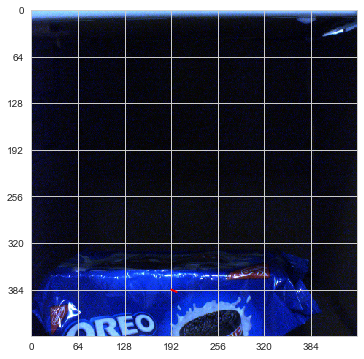

In [20]:
fig, axes = plt.subplots(1,1)
plt.xticks(range(0, 448, 64))
plt.yticks(range(0, 448, 64))
plt.imshow(images[0])
plt.plot([3*64, 3*64 + 0.117*64], [6*64, 6*64 + 0.052*64], 'r', lw=2)

## ミニバッチ時の学習データの抽出

In [21]:
batch_size = 10

In [22]:
n_train = len(labels)
n_train

749

In [23]:
perm = np.random.permutation(n_train)
perm[0:5]

array([746, 406, 561, 504, 252])

In [24]:
count = 0
ix = perm[count:count+batch_size]
x = chainer.Variable(xp.asarray(images[ix]).astype(np.float32).transpose(0,3,1,2))
t = chainer.Variable(xp.asarray(labels[ix].ravel()).astype(np.int32))

In [25]:
x.shape, t.shape

((10, 3, 448, 448), (10,))

## CNNモデルのセットアップ

TODO: 後でClassifierに名前を変更する

In [26]:
cnn_model = YoloTinyCNN()
cnn_optimizer = optimizers.Adam()
cnn_optimizer.setup(cnn_model)

In [27]:
cnn_model.train = True
cnn_optimizer.update(cnn_model, x, t)

In [28]:
cnn_model.loss.data, cnn_model.accuracy.data

(array(7.394410133361816, dtype=float32), array(0.0, dtype=float32))

In [29]:
# chainer.serializers.save_npz('cnn.model', cnn_model)
# chainer.serializers.save_npz('cnn.state', cnn_optimizer)

## 推論モデルのセットアップ

In [30]:
pred_model = YoloTiny()
pred_optimizer = optimizers.Adam()
pred_optimizer.setup(pred_model)

## 推論を実行

In [31]:
px, py, pw, ph, pconf, pprob = pred_model.forward(x)

px.data.shape, py.data.shape, pw.data.shape, ph.data.shape, pconf.data.shape, pprob.data.shape

((10, 1, 7, 7),
 (10, 1, 7, 7),
 (10, 1, 7, 7),
 (10, 1, 7, 7),
 (10, 1, 7, 7),
 (10, 26, 7, 7))

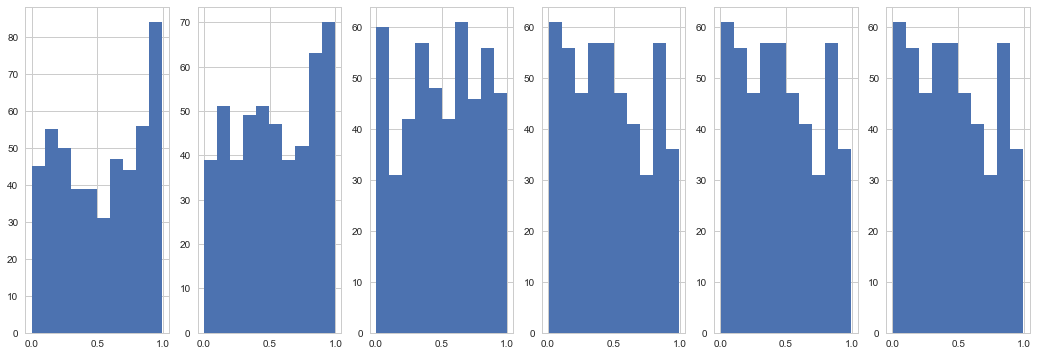

In [32]:
fig, axes = plt.subplots(1, 6, figsize=(18, 6))
axes[0].hist(px.data.flatten())
axes[1].hist(py.data.flatten())
axes[2].hist(pw.data.flatten())
axes[3].hist(ph.data.flatten())
axes[4].hist(ph.data.flatten())
axes[5].hist(ph.data.flatten())
pass

In [33]:
tx, ty, tw, th, tconf, tprob = np.array_split(ground_truths[0:batch_size], indices_or_sections=(1,2,3,4,5), axis=1)

tx.shape, ty.shape, tw.shape, tconf.shape, tprob.shape

((10, 1, 7, 7), (10, 1, 7, 7), (10, 1, 7, 7), (10, 1, 7, 7), (10, 26, 7, 7))

In [34]:
tx[0]

array([[[ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ,  0.1171875,  0.       ,
          0.       ,  0.       ]]], dtype=float32)

In [35]:
tx[tconf != 1.0] = 0.5

tx[0]

array([[[ 0.5      ,  0.5      ,  0.5      ,  0.5      ,  0.5      ,
          0.5      ,  0.5      ],
        [ 0.5      ,  0.5      ,  0.5      ,  0.5      ,  0.5      ,
          0.5      ,  0.5      ],
        [ 0.5      ,  0.5      ,  0.5      ,  0.5      ,  0.5      ,
          0.5      ,  0.5      ],
        [ 0.5      ,  0.5      ,  0.5      ,  0.5      ,  0.5      ,
          0.5      ,  0.5      ],
        [ 0.5      ,  0.5      ,  0.5      ,  0.5      ,  0.5      ,
          0.5      ,  0.5      ],
        [ 0.5      ,  0.5      ,  0.5      ,  0.5      ,  0.5      ,
          0.5      ,  0.5      ],
        [ 0.5      ,  0.5      ,  0.5      ,  0.1171875,  0.5      ,
          0.5      ,  0.5      ]]], dtype=float32)

In [36]:
((tx - px)**2).data[0]

array([[[  7.75818154e-02,   1.10331215e-01,   4.22508502e-03,
           9.56527963e-02,   2.20844001e-01,   1.06761465e-03,
           7.19184875e-02],
        [  1.25515968e-01,   1.23608783e-01,   1.46970481e-01,
           2.28976104e-02,   8.93491581e-02,   1.97995126e-01,
           4.54290472e-02],
        [  1.82557300e-01,   7.93871470e-03,   9.68563780e-02,
           3.69056799e-02,   8.45635161e-02,   6.86761574e-04,
           1.58067532e-02],
        [  1.20295726e-01,   1.19142674e-01,   4.46838997e-02,
           4.37349780e-03,   3.28079648e-02,   3.08148880e-02,
           3.81750353e-02],
        [  9.08806995e-02,   2.59468053e-02,   1.58395126e-01,
           3.44388373e-02,   1.61983773e-01,   7.96820298e-02,
           1.20515993e-03],
        [  2.88064741e-02,   2.17627183e-01,   1.72959827e-02,
           1.24627799e-01,   1.15850806e-01,   5.36177686e-06,
           1.73594981e-01],
        [  1.14246495e-01,   4.80879284e-02,   1.26434997e-01,
           3.

In [37]:
box_learning_scale = np.tile(0.1, tx.shape)
box_learning_scale[tconf == 1.0] = 1.0

box_learning_scale[0]

array([[[ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
        [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
        [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
        [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
        [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
        [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
        [ 0.1,  0.1,  0.1,  1. ,  0.1,  0.1,  0.1]]])

In [38]:
(box_learning_scale * ((tx - px)**2)).data[0]

array([[[  7.75818154e-03,   1.10331215e-02,   4.22508514e-04,
           9.56527982e-03,   2.20844001e-02,   1.06761465e-04,
           7.19184894e-03],
        [  1.25515973e-02,   1.23608783e-02,   1.46970479e-02,
           2.28976109e-03,   8.93491600e-03,   1.97995137e-02,
           4.54290491e-03],
        [  1.82557311e-02,   7.93871470e-04,   9.68563836e-03,
           3.69056803e-03,   8.45635217e-03,   6.86761559e-05,
           1.58067537e-03],
        [  1.20295724e-02,   1.19142672e-02,   4.46839025e-03,
           4.37349780e-04,   3.28079658e-03,   3.08148889e-03,
           3.81750357e-03],
        [  9.08807013e-03,   2.59468053e-03,   1.58395134e-02,
           3.44388373e-03,   1.61983781e-02,   7.96820316e-03,
           1.20515993e-04],
        [  2.88064755e-03,   2.17627194e-02,   1.72959827e-03,
           1.24627799e-02,   1.15850810e-02,   5.36177708e-07,
           1.73594989e-02],
        [  1.14246495e-02,   4.80879284e-03,   1.26435002e-02,
           3.

In [39]:
F.sum(box_learning_scale * ((tx - px)**2)).data

array(6.6791911125183105, dtype=float32)

In [40]:
tprob[0][1,:,:]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.]], dtype=float32)

In [41]:
_tprob = pprob.data.copy()
_tprob[tprob == 1.0] = 1.0
_tprob[0][1,:,:]

array([[ 0.24869117,  0.62510341,  0.92510629,  0.5648092 ,  0.66470855,
         0.04016432,  0.70306808],
       [ 0.41764426,  0.2252731 ,  0.66645342,  0.20233285,  0.93445522,
         0.82915592,  0.16191822],
       [ 0.23141804,  0.73260927,  0.24278146,  0.62464964,  0.26815552,
         0.54718029,  0.38511175],
       [ 0.39641684,  0.55142581,  0.27966735,  0.255068  ,  0.58343959,
         0.65209711,  0.34229419],
       [ 0.47763586,  0.85085022,  0.44686672,  0.2042872 ,  0.25320354,
         0.71217972,  0.21515208],
       [ 0.90066653,  0.50959903,  0.8488093 ,  0.0191159 ,  0.72227681,
         0.45340076,  0.34129325],
       [ 0.07505038,  0.40461874,  0.7870931 ,  1.        ,  0.79811084,
         0.77388179,  0.55377692]], dtype=float32)

In [42]:
((_tprob - pprob)**2).data[0][1,:,:]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.03783552,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [43]:
F.sum((_tprob - pprob)**2).data

array(2.0143351554870605, dtype=float32)

In [44]:
_tprob_err = F.reshape(F.sum(((_tprob - pprob) ** 2), axis=1), tconf.shape)
_tprob_err.data[0]

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.03783552,  0.        ,
          0.        ,  0.        ]]], dtype=float32)

In [45]:
prob_learning_scale = np.tile(0.0, tconf.shape)
prob_learning_scale[tconf == 1.0] = 1.0

In [46]:
F.sum(prob_learning_scale * F.reshape(F.sum(((_tprob - pprob) ** 2), axis=1), tconf.shape)).data

array(2.0143351554870605, dtype=float32)

## 推論結果を検出座標に変換

In [52]:
px, py, pw, ph, pconf, pprob = pred_model.forward(x)

px.shape, py.shape, pw.shape, ph.shape, pconf.shape, pprob.shape

((10, 1, 7, 7),
 (10, 1, 7, 7),
 (10, 1, 7, 7),
 (10, 1, 7, 7),
 (10, 1, 7, 7),
 (10, 26, 7, 7))

In [54]:
_px = F.reshape(px, (batch_size, N_GRID, N_GRID)).data
_py = F.reshape(py, (batch_size, N_GRID, N_GRID)).data
_pw = F.reshape(pw, (batch_size, N_GRID, N_GRID)).data
_ph = F.reshape(ph, (batch_size, N_GRID, N_GRID)).data
_pconf = F.reshape(pconf, (batch_size, N_GRID, N_GRID)).data
_pprob = pprob.data

_px.shape, _py.shape, _pw.shape, _ph.shape, _pconf.shape, _pprob.shape

((10, 7, 7), (10, 7, 7), (10, 7, 7), (10, 7, 7), (10, 7, 7), (10, 26, 7, 7))

In [75]:
_class_probs = _pprob[0] * _pconf[0]
_class_probs.shape

(26, 7, 7)

In [86]:
_candidate_map = _class_probs.max(axis=0) > 0.8
_candidate_label_map = _class_probs.argmax(axis=0)

In [144]:
_candidate_map

array([[False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [ True, False, False, False, False, False, False],
       [False, False, False, False,  True, False, False],
       [False, False, False, False, False, False,  True],
       [False, False, False, False, False, False,  True],
       [False, False, False, False, False, False,  True]], dtype=bool)

In [153]:
[{'x': point[0], 'y': point[1]} for point in np.argwhere(_candidate_map == True)]

[{u'x': 2, u'y': 0},
 {u'x': 3, u'y': 4},
 {u'x': 4, u'y': 6},
 {u'x': 5, u'y': 6},
 {u'x': 6, u'y': 6}]

In [88]:
_candidate_label_map

array([[ 9, 20,  8, 20, 11, 16, 15],
       [10, 11, 13, 11,  1, 12,  2],
       [12,  3, 25,  5,  5, 22, 20],
       [18, 15,  6,  3, 17, 24,  5],
       [10, 24,  4,  7, 20, 18, 13],
       [ 1,  7,  9, 19, 20,  8, 20],
       [ 8, 23, 17,  2, 13, 17, 16]])

In [107]:
_class_probs.max(axis=0)[_candidate_map]

array([ 0.80364388,  0.86708945,  0.82160211,  0.84443027,  0.81833756], dtype=float32)

In [109]:
_candidate_label_map[_candidate_map]

array([12, 17, 13, 20, 16])

In [99]:
_pprob[0].transpose(1,2,0)[_candidate_map][0].max() * _pconf[0][_candidate_map][0]

0.80364388

In [101]:
_pprob[0].transpose(1,2,0)[_candidate_map][0].argmax()

12

In [132]:
class Box():
    def __init__(self, x, y, w, h):
        self.left = x
        self.top = y
        self.right = x + w
        self.bottom = y + h

    @property
    def width(self):
        return self.right - self.left

    @property
    def height(self):
        return self.bottom - self.top

    @property
    def vertex(self):
        return ((self.left, self.top), (self.right-1, self.top),
                (self.left, self.bottom-1), (self.right-1, self.bottom-1))

    def area(self):
        return float(self.width * self.height)

    @classmethod
    def overlap(clazz, box1, box2):
        left = max(box1.left, box2.left)
        top = max(box1.top, box2.top)
        right = min(box1.right, box2.right)
        bottom = min(box1.bottom, box2.bottom)
        width = max(0, right - left)
        height = max(0, bottom - top)
        return Box(left, top, width, height)

    @classmethod
    def intersection(clazz, box1, box2):
        return Box.overlap(box1, box2).area()

    @classmethod
    def union(clazz, box1, box2):
        return box1.area() + box2.area() - Box.intersection(box1, box2)

    @classmethod
    def iou(clazz, box1, box2):
        return Box.intersection(box1, box2) / Box.union(box1, box2)

In [162]:
def __select_candidates(self, px, py, pw, ph, pconf, pprob, class_prob_thresh):
    class_prob_map = pprob * pconf # クラス確率を算出 (N_CLASSES,N_GRID,N_GRID)
    candidate_map = class_prob_map.max(axis=0) > class_prob_thresh # グリッド候補 (N_GRID,N_GRID)
    candidate_class_map = class_prob_map.argmax(axis=0) # グリッド候補のクラス (N_GRID,N_GRID)
    active_grid_cells = [{'x': point[0], 'y': point[1]} for point in np.argwhere(_candidate_map)] # グリッド候補の位置
    candidates = []
    for i in range(0, candidate_map.sum()):
        candidates.append({
            'box': Box(px[candidate_map][i], py[candidate_map][i],
                       pw[candidate_map][i], ph[candidate_map][i]),
            #'conf': pconf[candidate_map][i],
            #'prob': pprob.transpose(1,2,0)[candidate_map][i],
            'objectness': class_prob_map.max(axis=0)[candidate_map][i],
            'class': candidate_class_map[candidate_map][i],
            'active_grid_cell': active_grid_cells[i]
        })
    return candidates

In [163]:
def __nms(self, candidates, iou_thresh):
    sorted(candidates, key=lambda x: x['objectness'], reverse=True)
    winners = []

    if len(candidates) == 0:
        return winners

    winners.append(candidates[0]) # 第１候補は必ず採用
    for i in range(1, len(candidates)): # 第２候補以降は上位の候補とのIOU次第
        for j in range(0, i):
            if Box.iou(candidates[i]['box'], candidates[j]['box']) > iou_thresh:
                break
        else:
            winners.append(candidates[i])
    return winners

In [164]:
i = 0
candidates = __select_candidates(None, _px[i], _py[i], _pw[i], _ph[i], _pconf[i], _pprob[i], 0.8)
winners = __nms(None, candidates, 0.3)

len(candidates), len(winners)

(5, 5)

In [165]:
winners

[{u'active_grid_cell': {u'x': 2, u'y': 0},
  u'box': <__main__.Box instance at 0x17a2bb9e0>,
  u'class': 12,
  u'objectness': 0.80364388},
 {u'active_grid_cell': {u'x': 3, u'y': 4},
  u'box': <__main__.Box instance at 0x11385c290>,
  u'class': 17,
  u'objectness': 0.86708945},
 {u'active_grid_cell': {u'x': 4, u'y': 6},
  u'box': <__main__.Box instance at 0x11385c1b8>,
  u'class': 13,
  u'objectness': 0.82160211},
 {u'active_grid_cell': {u'x': 5, u'y': 6},
  u'box': <__main__.Box instance at 0x11385cbd8>,
  u'class': 20,
  u'objectness': 0.84443027},
 {u'active_grid_cell': {u'x': 6, u'y': 6},
  u'box': <__main__.Box instance at 0x11385c710>,
  u'class': 16,
  u'objectness': 0.81833756}]

In [172]:
def final_detection(result, real_width, real_height):
    grid_size = INPUT_SIZE / N_GRID
    pred_x = (result['box']).vertex[0][0]
    pred_y = (result['box']).vertex[0][1]
    pred_w = (result['box']).width
    pred_h = (result['box']).height
    active_grid_cell = result['active_grid_cell']
    
    return {
        'x': (active_grid_cell['x'] + pred_x) * grid_size * real_width / INPUT_SIZE,
        'y': (active_grid_cell['y'] + pred_y) * grid_size * real_height / INPUT_SIZE,
        'width': pred_w * real_width,
        'height': pred_h * real_height,
        'class': result['class'],
        'objectness': result['objectness']
    }


In [173]:
final_detection(winners[0], 1280, 960)

{u'class': 12,
 u'height': 342.82407760620117,
 u'objectness': 0.80364388,
 u'width': 971.07749938964844,
 u'x': 379.01398794991627,
 u'y': 102.22136633736747}

In [187]:
def check_correct_detection(pred, truths):
    # TODO: pred,truthsをBoxに変換
    best_iou, best_truth = Box.best_iou(pred, truth)
    if best_iou <= 0.5:
        return False
    if pred.class != best_truth.class
        return False
    return True

In [186]:
True + True

2

### モニタリングする指標
- 検出数
- mean average precision

In [176]:
arr = np.asarray([Box(1,2,3,4), Box(5,6,7,8)])
type(arr)

numpy.ndarray

In [185]:
np.savez('foo.npz', data=arr)
arr2 = np.load('foo.npz')

for box in arr2['data']:
    print (box.vertex[0], box.width, box.height)

(1, 2) 3 4
(5, 6) 7 8
